In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from scipy.spatial import distance_matrix
from itertools import product, repeat

from functools import partial
from itertools import repeat

In [4]:
from metadata import Metadata

In [5]:
from seqfish_config_brain_tmi import * 

In [6]:
# Some linux distributions of MKL and MP libraries will run operations multithreaded 
# under the hood. os.environ sets linux environmental variables that control this 
# behavior. Here we're limiting these libraries to using at most 2 threads (vs default ncpu)
# This way we can more predictably control system usage with python multiprocessing

# If you notice weird use of many mores than expected consider setting some of these environmental 
# variable. We can also consider setting them on a system wide level.
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['GOTO_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

In [7]:
from analysis_scripts.decon_codestacks import *
from fish_results import *

In [9]:
niter = 25
md_path = '/oasis/scratch/comet/rfor10/temp_project/scratch/TBI1_2_2018Sep22/'
k = 2
zstart = 4
zskip = 4
zmax = 25
ncpu = 16
out_path = '/oasis/scratch/comet/rfor10/temp_project/scratch/TBI1_2_2018Sep22/codestacks/'
tforms_path = '/oasis/scratch/comet/rfor10/temp_project/scratch/TBI1_2_2018Sep22/tforms.pkl'

In [9]:

if not os.path.exists(out_path):
    os.makedirs(out_path)

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['GOTO_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
pfunc = partial(hdata_multi_z_pseudo_maxprjZ_wrapper, md_path=md_path,
                bitmap=bitmap, k=k, zstart=zstart, zskip=zskip,
                zmax=zmax, cstk_save_dir=out_path, ndecon_iter=niter)
good_positions = pickle.load(open(tforms_path, 'rb'))['good']
func_inputs = []
for p, t in good_positions.items():
    tforms_xyz = {k: (v[0][0], v[0][1], int(np.round(np.mean(v[0][2])))) for k, v in t.items()}
    txy = {k: (v[0], v[1]) for k, v in tforms_xyz.items()}
    tzz = {k: v[2] for k, v in tforms_xyz.items()}
    func_inputs.append((HybeData(os.path.join(out_path, p)), p, txy, tzz))


In [ ]:
with multiprocessing.Pool(ncpu) as ppool:
    ppool.starmap(pfunc, func_inputs)

opening img_Pos230_000000005_000000000_Orange_000_005.tif

/home/rfor10/anaconda3/envs/py35/lib/python3.5/site-packages/skimage/restoration/deconvolution.py:389: RuntimeWarning: invalid value encountered in true_divide
  relative_blur = image / convolve_method(im_deconv, psf, 'same')


opening img_Pos199_000000006_000000000_Orange_000_006.tif

/home/rfor10/anaconda3/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


opening img_Pos177_000000014_000000000_FarRed_000_014.tif

In [10]:
cstk_path = out_path
ncpu = 16
niter = 1

bitmap = bitmap
normalized_gene_vectors = norm_gene_codeword_vectors

hybedatas = np.array([(i, HybeData(os.path.join(cstk_path, i)))
                      for i in os.listdir(cstk_path) if os.path.isdir(os.path.join(cstk_path, i))])


In [17]:
# hybe_datas = np.random.choice(range(len(hybedatas)), replace=False)
# hybedatas = hybedatas[hybe_datas]

In [20]:
len(hybedatas)

345

In [21]:
cur_nf = np.array([1854.94920095, 1956.84697151, 1491.64221487, 1990.23678207, 1597.11706861,
 1417.80383945, 1064.12388595, 1432.71069288, 1274.83525038, 1176.66421318,
 1228.44956319,  945.01303323,  770.40720558,  917.80425123,  600.,
 1598.87669802, 1002.39584208, 1305.16981665])

cur_nf = np.array([1822.32791798, 1926.9276165 , 1407.34557694, 1916.85531047 ,1597.71153926,
 1409.07447713, 1076.70038392, 1358.77256108, 1215.18888047 ,1163.01768772,
 1196.89902124 , 927.08289719 , 706.4010583  , 845.79319221  ,411.5541971,
 1525.85993416 , 919.46353106 ,1249.34887612])

cur_nf = np.array([1826.76309567, 1896.90962149, 1399.7004646  ,1873.63654872, 1594.16936133,
 1438.97185811, 1118.73842786 ,1393.67363755, 1250.00562148, 1209.60228504,
 1249.29801702 , 964.06691665 , 651.17108254,  789.50714039 , 398.10717055,
 1561.52102923,  952.89782031, 1259.73931371])

In [22]:
from analysis_scripts.hdata_iterative_classify_codestacks import *

In [ ]:
# Note preceding blocks and this can be noisy if restarted after crash etccc
# Note preceding blocks and this can be noisy if restarted after crash etccc
with multiprocessing.Pool(ncpu) as ppool:
    failed_positions = []
    for i in range(niter):
        print('N Positions left: ', len(hybedatas))
        if i == 0:
#             cur_nf = np.array(np.nanmean([mean_nfs(hdata, pos) for pos, hdata in hybedatas], axis=0))
            print('90th Percentile Normalization factors:', cur_nf, sep='\n')
        else:
            cur_nf = np.array(np.nanmean([mean_nfs(hdata, pos) for pos, hdata in hybedatas], axis=0))
            cur_nf = np.array([10**2.6 if (i<10**2.6) or np.isnan(i) else i for i in cur_nf])
            print(cur_nf)
        classify_pfunc = partial(classify_file, nfactor=cur_nf, nvectors=normalized_gene_vectors)
        results = ppool.starmap(classify_pfunc, [(i[1], i[0]) for i in hybedatas])

Pos347
Pos240
Pos375
Pos431
Pos216
Pos21
Pos366
Pos165
Pos385
Pos8
Pos51
Pos198
Pos275
Pos400
Pos249
Pos337
N Positions left:  345
90th Percentile Normalization factors:
[1826.76309567 1896.90962149 1399.7004646  1873.63654872 1594.16936133
 1438.97185811 1118.73842786 1393.67363755 1250.00562148 1209.60228504
 1249.29801702  964.06691665  651.17108254  789.50714039  398.10717055
 1561.52102923  952.89782031 1259.73931371]
Pos13


In [14]:
from analysis_scripts.parse_classification_images import *

In [17]:
pfunc = partial(multi_z_class_parse_wrapper, cvectors = normalized_gene_vectors, genes = gids)


inputs = [(h, p) for p, h in hybedatas]

In [22]:
import time

In [26]:
h.base_pth

AttributeError: 'HybeData' object has no attribute 'base_pth'

In [ ]:
tstart = time.time()
for idx, (h, p) in enumerate(inputs[130:]):
    print(idx, 'elapsed time: ', time.time()-tstart)
    try:
        df = pfunc(h, p)
    except:
        continue


0 elapsed time:  8.749961853027344e-05
1 elapsed time:  0.0006816387176513672
2 elapsed time:  31.240986108779907
3 elapsed time:  88.2392966747284
4 elapsed time:  121.803546667099
5 elapsed time:  162.52472305297852
6 elapsed time:  188.53444385528564
7 elapsed time:  225.60218858718872
8 elapsed time:  257.46485781669617
9 elapsed time:  322.5071704387665
10 elapsed time:  358.5366015434265
11 elapsed time:  381.8242361545563
12 elapsed time:  423.3552644252777
13 elapsed time:  462.9795219898224
14 elapsed time:  496.7184638977051
15 elapsed time:  539.4313402175903
16 elapsed time:  589.4526844024658
17 elapsed time:  608.2591400146484
18 elapsed time:  732.460010766983
19 elapsed time:  796.0979149341583
20 elapsed time:  825.1556053161621
21 elapsed time:  879.9041767120361
22 elapsed time:  936.8573617935181
23 elapsed time:  1013.6914784908295
24 elapsed time:  1080.4647698402405
25 elapsed time:  1111.8134779930115
26 elapsed time:  1136.9939918518066
27 elapsed time:  1207.6

In [21]:
df = pickle.load(open(h.base_path+'/spotcalls.pkl', 'rb'))
df.shape

(45035, 9)

In [ ]:
from analysis_scripts.parse_classification_images import *
vectors = np.concatenate((norm_gene_codeword_vectors, norm_blank_codeword_vectors))
combined_genes = gids+bids

with multiprocessing.Pool(16) as ppool:
    dfs = ppool.starmap(pfunc, inputs)
# bigdf = pd.concat(dfs, ignore_index=True)
# bigdf.shape

In [12]:
import pandas as pd

In [ ]:
dfs = []
for p, h in hybedatas:
    try:
        df = pickle.load(open(os.path.join(h.base_path, 'spotcalls.pkl'), 'rb'))
        dfs.append(df)
    except Exception as e:
        print(e)
        continue
bigdf = pd.concat(dfs, ignore_index=True)

In [ ]:
bigdf.shape

In [15]:
from stkshow import stkshow

In [25]:
from skimage.external.tifffile import TiffWriter
import subprocess
from shlex import split
from skimage import img_as_uint

def stkshow(images, fname='/home/rfor10/Downloads/tmp-stk.tif'):
    with TiffWriter(fname, bigtiff=False, imagej=True) as t:
        if len(images.shape)>2:
            for i in range(images.shape[2]):
                t.save(images[:,:,i].astype('uint16'))
        else:
            t.save(images.astype('uint16'))
#     java_cmd = ["java", "-Xmx5120m", "-jar", "/Users/robertf/ImageJ/ImageJ.app/Contents/Resources/Java/ij.jar"]
#     image_j_args = ["-ijpath", "/Users/robertf/ImageJ/", fname]
#     subprocess.Popen(java_cmd+image_j_args, shell=False,stdin=None,stdout=None,stderr=None,close_fds=True)

In [46]:
# Load bead data
posnames = !find /scratch/hybe_v2_test_2018Jul29/hdf3 -type f
bead_dicts = {p:{k.split('_')[0]:v for k,v in pickle.load(open(p, 'rb')).items()} for p in posnames}

In [7]:

from analysis_scripts.iterative_classify_codestacks import *
# Reclassify all the positions
cstk_pth = '/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2weeks_controlTreatment_2018Sep08/'
codestacks = !find {cstk_pth} -type f

In [19]:
cur_nf = [mean_nfs_npz(f) for f in codestacks]
cur_nf = np.nanmean(cur_nf, axis=0)
cur_nf = cur_nf*2.5
cur_nf

array([747.88372531, 691.61886074, 702.54682983, 693.53477519,
       662.47013655, 719.15113044, 468.14176125, 459.26702046,
       445.27010195, 438.34734726, 472.8885675 , 438.21563605,
       730.45144545, 771.06108632, 679.00610223, 444.8297567 ,
       451.86460119, 515.46104636])

In [32]:
cur_nf = [1373.97382855, 1472.58443477,  958.96826324, 1605.91032058, 1213.94019318,
 1227.23756409 , 891.93879809,  883.15777751,  727.48006846,  848.43114065,
  861.73735941,  849.51469367 , 572.48569752 , 870.17985429 , 805.70688392,
  436.92912871,  827.22407427  ,903.14771067  ,741.52142207 ,1238.75738052,
  772.01915741,  994.52341435 , 899.88538513, 1008.13691975]
og = np.array([1216.6536594 ,  932.73314234, 1217.07839664, 1022.99498985,
        935.88290512, 1131.0476524 ,  759.44292817,  820.19374442,
        881.21312459,  549.08566491,  757.61432318,  424.50103792,
        948.3886926 , 1302.47084947,  434.23132817,  710.90645811,
        747.88516914,  877.10345139])

cur_nf= np.array([1294.55360667,  972.7720689 , 1257.38464716, 1031.25508577,
        950.06063175, 1169.97829866,  792.73001758,  811.26088998,
        846.82009248,  567.90415733,  770.61972207,  410.97531894,
        950.41498705, 1362.78551229,  461.16891257,  709.14729095,
        753.30820417,  872.08112172])
og = np.array([1276.26776892,  969.76130107, 1249.13338855, 1029.7410021 ,
        944.46876093, 1146.99797893,  777.29377208,  804.66153989,
        798.25788766,  562.73718735,  771.16002639,  425.61204881,
        898.43008425, 1346.15923485,  448.45322675,  699.54254564,
        746.12259983,  862.68503674])
og = np.array([1516.71578345,  838.95637041, 1565.15936049, 1013.14198072,
        919.31306454, 1201.45433538,  930.35760399,  938.78660735,
        952.03727153,  520.74134211,  822.98161306,  249.20840509,
        694.50665744, 1408.02438354,  272.82722013,  609.7461287 ,
        763.69888809,  942.62919018])

In [44]:
og/cur_nf

array([1.17161296, 0.86243879, 1.24477372, 0.98243586, 0.96763621,
       1.02690309, 1.17361218, 1.15719446, 1.12424974, 0.91695286,
       1.06794777, 0.6063829 , 0.73074043, 1.03319589, 0.59159933,
       0.85983002, 1.0137934 , 1.08089622])

In [ ]:
norm_gene_codeword_vectors

In [31]:
len(codestacks)

67

In [19]:
nvectors.shape

(37, 18)

In [ ]:
import multiprocessing
import warnings
# Suppress warnings going to stdout
warnings.filterwarnings("ignore")

for i in range(10):

    with multiprocessing.Pool(24) as ppool:
        classify_pfunc = partial(classify_file, nfactor=cur_nf, nvectors=norm_gene_codeword_vectors)
        results = ppool.map(classify_pfunc, codestacks)
    new_nf = []
    for i in range(3):
        for c in codestacks:
            try:
                nf = mean_nfs_npz(c)
                print(nf)
                new_nf.append(nf)
            except:
                codestacks.remove(c)
                print(c)
        og = cur_nf
        cur_nf = np.nanmean(new_nf, axis=0)
        print(cur_nf/og)

13-Pos_002_009.npz
13-Pos_007_010.npz
13-Pos_000_013.npz
13-Pos_000_004.npz
13-Pos_004_004.npz
13-Pos_006_011.npz
13-Pos_003_008.npz
13-Pos_001_003.npz
13-Pos_001_002.npz
13-Pos_006_009.npz
13-Pos_008_015.npz
13-Pos_007_008.npz
13-Pos_013_006.npz
13-Pos_006_013.npz
13-Pos_006_006.npz
13-Pos_003_003.npz
13-Pos_003_016.npz
13-Pos_007_016.npz
13-Pos_004_013.npz
13-Pos_007_003.npz
13-Pos_011_008.npz
13-Pos_013_010.npz
13-Pos_005_012.npz
13-Pos_015_008.npz


In [83]:
new_nf = []
for i in range(3):
    for c in codestacks:
        try:
            nf = mean_nfs_npz(c)
            print(nf)
            new_nf.append(nf)
        except:
            codestacks.remove(c)
            print(c)
    og = cur_nf
    cur_nf = np.nanmean(new_nf, axis=0)
    print(cur_nf/og)

/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2weeks_controlTreatment_2018Sep08/13-Pos_006_009.npz
/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2weeks_controlTreatment_2018Sep08/13-Pos_006_007.npz
/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2weeks_controlTreatment_2018Sep08/13-Pos_007_010.npz
/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2weeks_controlTreatment_2018Sep08/13-Pos_008_015.npz
/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2weeks_controlTreatment_2018Sep08/13-Pos_001_002.npz
/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2weeks_controlTreatment_2018Sep08/13-Pos_004_004.npz
/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2weeks_controlTreatment_2018Sep08/13-Pos_005_014.npz
/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2weeks_controlTreatment_2018Sep08/13-Pos_006_011.npz
/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2weeks_controlTreatment_2018Sep08/13-Pos_003_008.npz
/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2we

NameError: name 'cur_nf' is not defined

> <ipython-input-83-38a883c07b99>(11)<module>()
      9             codestacks.remove(c)
     10             print(c)
---> 11     og = cur_nf
     12     cur_nf = np.nanmean(new_nf, axis=0)
     13     print(cur_nf/og)

ipdb> q


In [31]:
cur_nf/og

array([1.53931539, 0.78300204, 1.74267154, 1.06454644, 1.13928824,
       1.1518901 , 1.48620616, 1.47467461, 1.33309271, 1.06644707,
       1.23009893, 0.42210172, 0.66144132, 1.06467069, 0.4699304 ,
       0.77180339, 1.14605579, 1.27734458])

In [22]:
len(codestacks)

45

In [77]:
import multiprocessing

In [79]:
# Reclassify all the positions
cstk_pth = '/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2weeks_controlTreatment_2018Sep08/'
codestacks = !find {cstk_pth} -type f
codestacks = [i for i in codestacks if i.endswith('.npz')]

OSError: Failed to interpret file '/oasis/scratch/comet/rfor10/temp_project/freezerEtoh2weeks_controlTreatment_2018Sep08/13-Pos_002_011.npz' as a pickle

> /home/rfor10/anaconda3/envs/py35/lib/python3.5/multiprocessing/pool.py(644)get()
    642             return self._value
    643         else:
--> 644             raise self._value
    645 
    646     def _set(self, i, obj):

ipdb> q


In [36]:
bigdf = bigdf[bigdf['mean']>10**2.5]

In [42]:
bigdf = bigdf[bigdf.npixels>2]

In [40]:
fpkm

array([83.20299])

In [19]:
bigdf.shape

(936504, 9)

In [28]:
expression = pd.read_csv('/home/rfor10/Download/GSE102849_read_counts.txt', delimiter=' ')


SpearmanrResult(correlation=0.7662399241346608, pvalue=3.246208840711453e-08)


Text(-8.5,12.5,'Spearman Correlation: 0.85')

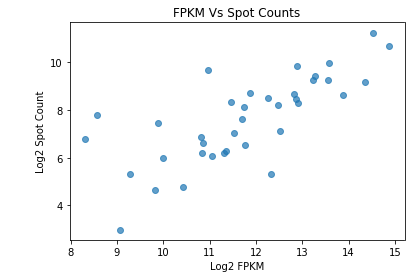

In [32]:
from collections import Counter
gene_mean_intensity_thresh = 500
counts = Counter(bigdf[(bigdf['ave']>gene_mean_intensity_thresh) & (bigdf['npixels']>2)].gene)
means = []


expression = pd.read_csv('/home/rfor10/Download/GSE102849_read_counts.txt', delimiter=' ')
vals = []
for gn, cc in counts.items():
    fpkm = expression[expression.refGene==gn]['BRSEQ08'].values
    if len(fpkm)>0:
        vals.append((fpkm[0], cc/45))
fpkms, ccs = zip(*vals)
ccs = list(np.array(ccs))
from scipy.stats import spearmanr
plt.scatter(np.log2(fpkms), np.log2(ccs), alpha=0.7)
print(spearmanr(fpkms, ccs))
plt.title('FPKM Vs Spot Counts')
plt.xlabel('Log2 FPKM')
plt.ylabel('Log2 Spot Count')
plt.annotate('Spearman Correlation: 0.85', xy=(-8.5,12.5))

In [67]:
from collections import Counter
counts = Counter()
means = []
for d in dfs:
    d = d[d.npixels>3]
    counts.update(d.gene.values)
    means += list(d['mean'].values)
    
expression = pd.read_excel('/home/rfor10/calcium_gene_table.csv-4.xlsx')

vals = []
for gn, cc in counts.items():
    fpkm = expression[expression.Gene==gn].FPKM.values
    if len(fpkm)>0:
        vals.append((fpkm[0], cc))
fpkms, ccs = zip(*vals)
ccs = list(np.array(ccs)/(100))
from scipy.stats import spearmanr
plt.scatter(np.log2(fpkms), np.log2(ccs))

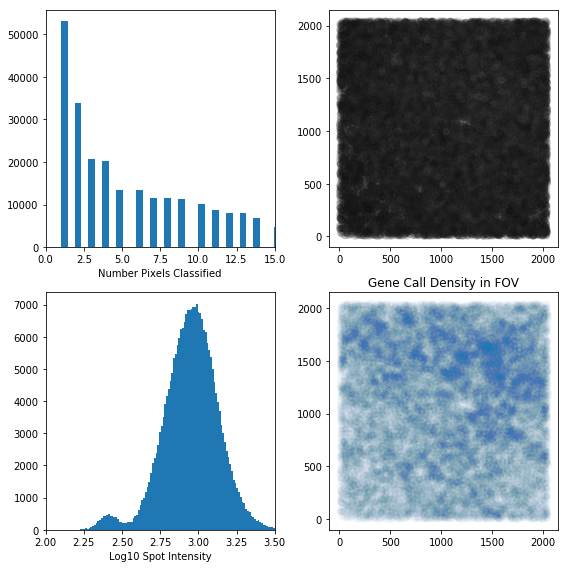

In [57]:
npixels = bigdf.npixels
brightness = bigdf['mean']
sample_idx = np.random.choice(list(range(bigdf.shape[0])), size=50000, replace=False)
x, y = zip(*bigdf.loc[sample_idx].centroid)
samp_means = bigdf.loc[sample_idx]['mean']

fix, ax = plt.subplots(2,2, figsize=(8, 8))
ax[0,0].hist(npixels, bins=100)
ax[0,0].set_xlim([0, 15])
ax[0,0].set_xlabel('Number Pixels Classified')
ax[0,1].scatter(x, y, c=samp_means, alpha=0.1, cmap=cm.gray)
ax[1,0].hist(np.log10(brightness), bins=200)
ax[1,0].set_xlim([2, 3.5])
ax[1,0].set_xlabel('Log10 Spot Intensity')
ax[1,1].scatter(x, y, alpha=0.01)
ax[1,1].set_title('Gene Call Density in FOV')
plt.tight_layout()

In [61]:
counts.keys()

dict_keys(['Mpped1', 'Slc17a7', 'Klf13', 'Kcnh7', 'Klhl2', 'Ntm', 'Ptprn', 'Slc7a14', 'Slc5a3', 'Slc39a6', 'Acvr1c', 'Auts2', 'Hsph1', 'Prox1', 'Sema5a', 'S1pr3', 'Dlg4', 'Serpina3n', 'Ext1', 'Npnt', 'Nt5dc3', 'Calb1', 'Slc29a4', 'Hbegf', 'Zdhhc2', 'Dock10', 'Kcnd2', 'Plekha2', 'Pmepa1', 'Il1rap', 'Fibcd1', 'Chst1', 'Inhba', 'Fgfr3'])

In [60]:
expression['TissueExpression (FPKM)']

,Gene,NumOligos,TissueExpression (FPKM),Unnamed: 3,Astrocytes,CA1,CA Subtype1,CA Subtype2,DG,Endothelial,...,Ependymal.1,GABAergic.1,Microglia.1,MossyCells.1,Oligo.1,OligoPCs.1,Pericytes.1,SMCs.1,Unknown1.1,Unknown2.1
0,Acvr1c,64,2.520271,NaN,0.019944,0.291152,0.315235,0.000000,0.314096,0.000000,...,0.000000,0.518354,0.038250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Arhgap12,6,5.897270,NaN,0.520694,1.431014,0.216117,0.335356,0.614822,0.536421,...,0.608961,0.000000,0.510292,0.000000,0.257816,0.478625,0.674217,0.599664,1.697118,0.438537
2,Arl15,64,0.608844,NaN,0.075192,0.497011,0.280792,0.000000,0.097241,0.526705,...,0.000000,0.000000,0.155199,0.345495,0.071493,0.128152,0.148664,0.000000,0.000000,0.000000
3,Auts2,64,20.415560,NaN,0.429087,0.828754,1.606801,0.442954,2.469744,0.267981,...,0.000000,1.470580,0.114173,3.499754,0.270379,0.228027,0.110903,0.000000,0.401671,0.313965
4,Cacybp,29,33.363497,NaN,2.042431,3.669608,3.067006,3.669151,2.187999,1.187802,...,2.576203,4.182231,1.486913,3.795898,1.327246,3.116600,2.154937,1.179726,8.925241,0.772186
5,Calb1,64,30.953463,NaN,0.141643,2.041780,1.638767,0.058719,6.545348,0.081162,...,0.065381,5.812914,0.026558,0.000000,0.027654,0.000000,0.000000,0.000000,0.405581,0.268240
6,Chst1,64,8.204343,NaN,1.442247,3.087122,1.472295,2.204750,3.552920,0.049719,...,0.000000,1.879945,0.520039,0.000000,0.160609,0.105867,0.275862,0.000000,0.000000,0.066489
7,Cpne8,4,0.012142,NaN,0.198819,1.270844,1.485613,0.109342,0.087191,0.545196,...,0.279686,0.417853,0.000000,0.399106,0.026616,0.694942,0.362691,0.000000,0.000000,0.454363
8,Cyp7b1,45,8.540541,NaN,1.816184,0.323380,0.295026,0.369783,1.351872,0.130744,...,0.251076,0.000000,0.013243,0.000000,0.042383,0.340115,0.297573,0.813140,0.000000,0.189050
9,Dbp,38,0.000000,NaN,3.163163,1.084258,1.191212,1.184850,0.695300,2.927877,...,1.332808,1.043075,0.151896,0.759228,0.190424,0.901568,2.062518,0.599664,4.407914,3.042518
